# MIE424 (2023 Winter) Lab 11 Decision Trees

Presented by Bo Tang

In this lab, you will dive into the decision tree, specifically focusing on the Classification and Regression Tree (CART) algorithm.

CART is a versatile algorithm capable of producing both classification trees (where the target variable is categorical) and regression trees (where the target variable is continuous). It employs a greedy approach, recursively splitting the data into subsets that maximize information gain for classification or minimize mean squared error for regression. However, it s important to note that the CART algorithm is heuristic and does not guarantee the generation of an optimal decision tree.

The `scikit-learn` library in Python offers an implementation of CART, to build and evaluate decision trees on real-world data.

## Import Packages

In [1]:
!pip install mlxtend
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn import tree as sktree
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt

## CART Implementation

In this exercise, you are tasked with implementing the core logic that decision trees use to decide where to split the data. Specifically, you will calculate the information gain resulting from splitting the data based on different thresholds of a feature.

The missing part is in method `_grow_tree`.

In [2]:
class CART(object):
    def __init__(self, tree="cls", criterion="gini", prune="depth", max_depth=4, min_criterion=0.05):
        # init decision tree parameters
        self.feature = None # feature used for splitting
        self.label = None # label of the node
        self.n_samples = None # number of samples at the node
        self.depth = 0 # depth of node
        self.root = None # root of tree
        self.left = None # left subtree
        self.right = None # right subtree
        self.threshold = None # threshold for splitting
        self.gain = None # information gain
        # init CART tree parameters
        self.tree = tree # type of tree (classification or regression)
        self.criterion = criterion # criterion for impurity calculation
        self.prune = prune # pruning method
        self.max_depth = max_depth # maximum depth of the tree
        self.min_criterion = min_criterion # minimum criterion for splitting

    def fit(self, features, target):
        """
        A method to train decision decision tree
        """
        # create the root node
        self.root = CART()
        # build the tree
        self.root._grow_tree(features, target, self.criterion)
        # orune the tree
        self.root._prune(self.prune, self.max_depth, self.min_criterion, self.root.n_samples)

    def predict(self, features):
        """
        A method to predict labels for input features
        """
        return np.array([self.root._predict(f) for f in features])

    def _grow_tree(self, features, target, criterion = 'gini'):
        """
        A method to grow the tree recursively
        """
        # update the number of samples at the node
        self.n_samples = features.shape[0]

        # if all targets are the same, set the label of the node
        if len(np.unique(target)) == 1:
            self.label = target[0]
            return
        # select the most frequently occuring class to be the label
        self.label = max([(c, len(target[target == c])) for c in np.unique(target)], key = lambda x : x[1])[0]

        # init best
        best_gain = 0.0 # best gain
        best_feature = None # best feature for splitting
        best_threshold = None # best threshold for splitting
        # calculate the current impurity of the node
        impurity_node = self._calc_impurity(criterion, target)
        # iterate through all features to find the best split
        for col in range(features.shape[1]):
            feature_level = np.unique(features[:,col])
            # calculate thresholds as midpoints between consecutive feature values
            thresholds = (feature_level[:-1] + feature_level[1:]) / 2.0
            # iterate through all thresholds to find the best split
            for threshold in thresholds:
                ########################### Fill in ###########################
                # split the data and calculate impurity for each subset
                # impurity of left
                target_l = target[features[:,col] <= threshold]
                impurity_l = self._calc_impurity(criterion, target_l)
                n_l = target_l.shape[0] / self.n_samples
                # impurity of right
                target_r = target[features[:,col] > threshold]
                impurity_r = self._calc_impurity(criterion, target_r)
                n_r = target_r.shape[0] / self.n_samples
                # calculate the information gain from this split
                impurity_gain = impurity_node - (n_l * impurity_l + n_r * impurity_r)
                # update best information gain
                if impurity_gain > best_gain:
                    best_gain = impurity_gain
                    best_feature = col
                    best_threshold = threshold
        # set the best feature, threshold, and gain for the current node
        self.feature = best_feature
        self.gain = best_gain
        self.threshold = best_threshold
        # recursively grow the left and right subtrees
        if best_gain > 0:
            self._split_tree(features, target, criterion)

    def _split_tree(self, features, target, criterion):
        """
        A method to split the data based on the best feature and threshold
        """
        # split the data to left based on the feature and threshold
        features_l = features[features[:, self.feature] <= self.threshold]
        target_l = target[features[:, self.feature] <= self.threshold]
        # build the left subtree
        self.left = CART() # create the left node
        self.left.depth = self.depth + 1 # increment depth for the child node
        self.left._grow_tree(features_l, target_l, criterion) # grow the left subtree
        # split the data to right based on the feature and threshold
        features_r = features[features[:, self.feature] > self.threshold]
        target_r = target[features[:, self.feature] > self.threshold]
        # build the right subtree
        self.right = CART() # create the right node
        self.right.depth = self.depth + 1 # increment depth for the child node
        self.right._grow_tree(features_r, target_r, criterion) # grow the right subtree

    def _calc_impurity(self, criterion, target):
        """
        A method to calculate the impurity of a node using Gini or entropy
        """
        # Gini impurity calculation
        if criterion == "gini":
            return 1.0 - sum([(float(len(target[target == c])) / float(target.shape[0])) ** 2.0 for c in np.unique(target)])
        # entropy calculation
        else:
            entropy = 0.0
            for c in np.unique(target):
                p = float(len(target[target == c])) / target.shape[0]
                if p > 0.0:
                    entropy -= p * np.log2(p)
            return entropy

    def _prune(self, method, max_depth, min_criterion, n_samples):
        """
        A method to prune the tree by impurity or depth
        """
        # it is a leaf node, no prune
        if self.feature is None:
            return
        # prune the left and right subtrees recursively
        self.left._prune(method, max_depth, min_criterion, n_samples)
        self.right._prune(method, max_depth, min_criterion, n_samples)
        # decide whether to prune this node based on the pruning method
        if method == "impurity" and self.left.feature is None and self.right.feature is None:
            if (self.gain * float(self.n_samples) / n_samples) < min_criterion:
                 # convert into a leaf node
                self.left = None
                self.right = None
                self.feature = None
        elif method == "depth" and self.depth >= max_depth:
            # convert into a leaf node
            self.left = None
            self.right = None
            self.feature = None

    def _predict(self, d):
        """
        # A medthod to predict the label for a given instance
        """
        # this is not a leaf node, traverse further down the tree
        if self.feature != None:
            # traverse to left subtree
            if d[self.feature] <= self.threshold:
                return self.left._predict(d)
            # traverse to right subtree
            else:
                return self.right._predict(d)
        # this is a leaf node, return the label
        else:
            return self.label

    def print_tree(self):
        """
        A method to print the tree structure
        """
        self.root._show_tree(0, " ")

    def _show_tree(self, depth, cond):
        """
        A helper method to print the tree structure
        """
        base = "    " * depth + cond
        if self.feature != None:
            print(base + "if X[" + str(self.feature) + "] <= " + str(self.threshold))
            self.left._show_tree(depth+1, "then ")
            self.right._show_tree(depth+1, "else ")
        else:
            print(base + "{value: " + str(self.label) + ", samples: " + str(self.n_samples) + "}")

## Data Preparation

Use the Iris dataset, a simple dataset, for the experiment

In [3]:
iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Training and Evaluation

Now we can compare the performance with the CART from the `scikit-learn`.

Both are configured to use the "entropy" criterion.

In [4]:
# implemented CART
cls = CART(tree="cls", criterion="entropy", prune="depth", max_depth=3)
cls.fit(X_train, y_train)
cls.print_tree()
pred = cls.predict(X_test)
print("This Classification Tree Prediction Accuracy:    {}".format(sum(pred == y_test) / len(pred)))

# sklearn decision tree
clf = sktree.DecisionTreeClassifier(criterion="entropy", max_depth=3)
clf = clf.fit(X_train, y_train)
sk_pred = clf.predict(X_test)
print("Sklearn Library Tree Prediction Accuracy:        {}".format(sum(sk_pred == y_test) / len(pred)))

 if X[2] <= 2.45
    then {value: 0, samples: 35}
    else if X[2] <= 4.75
        then if X[3] <= 1.65
            then {value: 1, samples: 34}
            else {value: 2, samples: 1}
        else if X[2] <= 5.15
            then {value: 2, samples: 16}
            else {value: 2, samples: 26}
This Classification Tree Prediction Accuracy:    0.9736842105263158
Sklearn Library Tree Prediction Accuracy:        0.9736842105263158


Using the Gini criterion instead:

In [5]:
# custom CART
cls = CART(tree="cls", criterion="gini", prune="depth", max_depth=3, min_criterion=0)
cls.fit(X_train, y_train)
cls.print_tree()
pred = cls.predict(X_test)
print("This Classification Tree Prediction Accuracy:    {}".format(sum(pred == y_test) / len(pred)))

# sklearn decision tree
clf = sktree.DecisionTreeClassifier(criterion="gini", max_depth=3)
clf.fit(X_train, y_train)
sk_pred = clf.predict(X_test)
print("Sklearn Library Tree Prediction Accuracy:        {}".format(sum(sk_pred == y_test) / len(pred)))

 if X[2] <= 2.45
    then {value: 0, samples: 35}
    else if X[2] <= 4.75
        then if X[3] <= 1.65
            then {value: 1, samples: 34}
            else {value: 2, samples: 1}
        else if X[3] <= 1.75
            then {value: 1, samples: 8}
            else {value: 2, samples: 34}
This Classification Tree Prediction Accuracy:    1.0
Sklearn Library Tree Prediction Accuracy:        1.0


## Visualizing the decision boundary

In [6]:
# reduce feature set to 2 dimensions for visualizations
X_new = X[:,[2,3]] # reduce feature set to 2 dimensions for visualizations
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_new, y, random_state = 42)

In [7]:
# custom CART
cls = CART(tree="cls", criterion="entropy", prune="depth", max_depth=3)
cls.fit(X_train, y_train)
cls.print_tree()
pred = cls.predict(X_test)
print("This Classification Tree Prediction Accuracy:    {}".format(sum(pred == y_test) / len(pred)))

 if X[0] <= 2.45
    then {value: 0, samples: 35}
    else if X[0] <= 4.75
        then if X[1] <= 1.65
            then {value: 1, samples: 34}
            else {value: 2, samples: 1}
        else if X[0] <= 5.15
            then {value: 2, samples: 16}
            else {value: 2, samples: 26}
This Classification Tree Prediction Accuracy:    0.9736842105263158


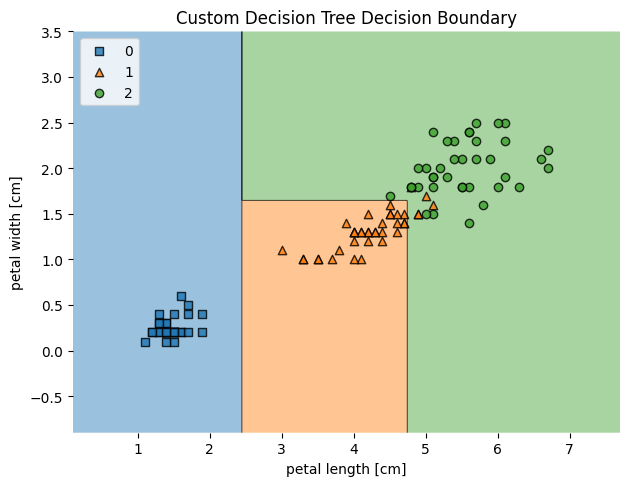

In [8]:
# draw plot
plot_decision_regions(X_train, y_train, cls)
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.title("Custom Decision Tree Decision Boundary")
plt.show()

## (Bonus) Optimal Decision Tree

Algorithms like CART and ID3 use greedy strategies to build decision trees by making locally optimal choices at each node. However, these choices might not lead to the globally optimal tree.

A notable advancement in this area is the Optimal Classification Tree (OCT) algorithm proposed by [Bertsimas and Dunn]((https://link.springer.com/article/10.1007/s10994-017-5633-9). OCT approaches decision tree construction as a Mixed Integer Programming (MIP) problem, allowing for the direct optimization of the tree structure with respect to a global objective function.

The implementation of this algorithm is available in a [Github Repo](https://github.com/LucasBoTang/Optimal_Classification_Trees). This Repo also contains other optimal decision tree models.

In [9]:
!pip install gurobipy
from collections import namedtuple
from scipy import stats
import gurobipy as gp
from gurobipy import GRB

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 24.1 MB/s eta 0:00:00


In [10]:
class optimalDecisionTreeClassifier:
    """
    optimal classification tree
    """
    def __init__(self, max_depth=3, min_samples_split=2, alpha=0, warmstart=True, timelimit=600, output=True):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.alpha = alpha
        self.warmstart = warmstart
        self.timelimit = timelimit
        self.output = output
        self.trained = False
        self.optgap = None
        # node index
        self.n_index = [i+1 for i in range(2 ** (self.max_depth + 1) - 1)]
        self.b_index = self.n_index[:-2**self.max_depth] # branch nodes
        self.l_index = self.n_index[-2**self.max_depth:] # leaf nodes

    def fit(self, x, y):
        """
        fit training data
        """
        # data size
        self.n, self.p = x.shape
        if self.output:
            print('Training data include {} instances, {} features.'.format(self.n,self.p))

        # labels
        self.labels = np.unique(y)

        # scale data
        self.scales = np.max(x, axis=0)
        self.scales[self.scales == 0] = 1

        # solve MIP
        m, a, b, c, d, l = self._buildMIP(x/self.scales, y)
        if self.warmstart:
            self._setStart(x, y, a, c, d, l)
        m.optimize()
        self.optgap = m.MIPGap

        # get parameters
        self._a = {ind:a[ind].x for ind in a}
        self._b = {ind:b[ind].x for ind in b}
        self._c = {ind:c[ind].x for ind in c}
        self._d = {ind:d[ind].x for ind in d}

        self.trained = True

    def predict(self, x):
        """
        model prediction
        """
        if not self.trained:
            raise AssertionError('This optimalDecisionTreeClassifier instance is not fitted yet.')

        # leaf label
        labelmap = {}
        for t in self.l_index:
            for k in self.labels:
                if self._c[k,t] >= 1e-2:
                    labelmap[t] = k
        y_pred = []
        for xi in x/self.scales:
            t = 1
            while t not in self.l_index:
                right = (sum([self._a[j,t] * xi[j] for j in range(self.p)]) + 1e-9 >= self._b[t])
                if right:
                    t = 2 * t + 1
                else:
                    t = 2 * t
            # label
            y_pred.append(labelmap[t])

        return np.array(y_pred)

    def _buildMIP(self, x, y):
        """
        build MIP formulation for Optimal Decision Tree
        """
        # create a model
        m = gp.Model('m')
        # output
        m.Params.outputFlag = self.output
        m.Params.LogToConsole = self.output
        # time limit
        m.Params.timelimit = self.timelimit
        # parallel
        m.params.threads = 0
        # model sense
        m.modelSense = GRB.MINIMIZE
        # variables
        a = m.addVars(self.p, self.b_index, vtype=GRB.BINARY, name='a') # splitting feature
        b = m.addVars(self.b_index, vtype=GRB.CONTINUOUS, name='b') # splitting threshold
        c = m.addVars(self.labels, self.l_index, vtype=GRB.BINARY, name='c') # node prediction
        d = m.addVars(self.b_index, vtype=GRB.BINARY, name='d') # splitting option
        z = m.addVars(self.n, self.l_index, vtype=GRB.BINARY, name='z') # leaf node assignment
        l = m.addVars(self.l_index, vtype=GRB.BINARY, name='l') # leaf node activation
        L = m.addVars(self.l_index, vtype=GRB.CONTINUOUS, name='L') # leaf node misclassified
        M = m.addVars(self.labels, self.l_index, vtype=GRB.CONTINUOUS, name='M') # leaf node samples with label
        N = m.addVars(self.l_index, vtype=GRB.CONTINUOUS, name='N') # leaf node samples
        # calculate baseline accuracy
        baseline = self._calBaseline(y)
        # calculate minimum distance
        min_dis = self._calMinDist(x)
        # objective function
        obj = L.sum() / baseline + self.alpha * d.sum()
        m.setObjective(obj)
        # constraints
        # (20)
        m.addConstrs(L[t] >= N[t] - M[k,t] - self.n * (1 - c[k,t]) for t in self.l_index for k in self.labels)
        # (21)
        m.addConstrs(L[t] <= N[t] - M[k,t] + self.n * c[k,t] for t in self.l_index for k in self.labels)
        # (17)
        m.addConstrs(gp.quicksum((y[i] == k) * z[i,t] for i in range(self.n)) == M[k,t]
                                 for t in self.l_index for k in self.labels)
        # (16)
        m.addConstrs(z.sum('*', t) == N[t] for t in self.l_index)
        # (18)
        m.addConstrs(c.sum('*', t) == l[t] for t in self.l_index)
        # (13) and (14)
        for t in self.l_index:
            left = (t % 2 == 0)
            ta = t // 2
            while ta != 0:
                if left:
                    m.addConstrs(gp.quicksum(a[j,ta] * (x[i,j] + min_dis[j]) for j in range(self.p))
                                 +
                                 (1 + np.max(min_dis)) * (1 - d[ta])
                                 <=
                                 b[ta] + (1 + np.max(min_dis)) * (1 - z[i,t])
                                 for i in range(self.n))
                else:
                    m.addConstrs(gp.quicksum(a[j,ta] * x[i,j] for j in range(self.p))
                                 >=
                                 b[ta] - (1 - z[i,t])
                                 for i in range(self.n))
                left = (ta % 2 == 0)
                ta //= 2
        # (8)
        m.addConstrs(z.sum(i, '*') == 1 for i in range(self.n))
        # (6)
        m.addConstrs(z[i,t] <= l[t] for t in self.l_index for i in range(self.n))
        # (7)
        m.addConstrs(z.sum('*', t) >= self.min_samples_split * l[t] for t in self.l_index)
        # (2)
        m.addConstrs(a.sum('*', t) == d[t] for t in self.b_index)
        # (3)
        m.addConstrs(b[t] <= d[t] for t in self.b_index)
        # (5)
        m.addConstrs(d[t] <= d[t//2] for t in self.b_index if t != 1)

        return m, a, b, c, d, l

    @staticmethod
    def _calBaseline(y):
        """
        obtain baseline accuracy by simply predicting the most popular class
        """
        mode = stats.mode(y)[0]
        return np.sum(y == mode)

    @staticmethod
    def _calMinDist(x):
        """
        get the smallest non-zero distance of features
        """
        min_dis = []
        for j in range(x.shape[1]):
            xj = x[:,j]
            # drop duplicates
            xj = np.unique(xj)
            # sort
            xj = np.sort(xj)[::-1]
            # distance
            dis = [1]
            for i in range(len(xj)-1):
                dis.append(xj[i] - xj[i+1])
            # min distance
            min_dis.append(np.min(dis) if np.min(dis) else 1)
        return min_dis

    def _setStart(self, x, y, a, c, d, l):
        """
        set warm start from CART
        """
        # train with CART
        if self.min_samples_split > 1:
            clf = sktree.DecisionTreeClassifier(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
        else:
            clf = sktree.DecisionTreeClassifier(max_depth=self.max_depth)
        clf.fit(x, y)

        # get splitting rules
        rules = self._getRules(clf)

        # fix branch node
        for t in self.b_index:
            # not split
            if rules[t].feat is None or rules[t].feat == sktree._tree.TREE_UNDEFINED:
                d[t].start = 0
                for f in range(self.p):
                    a[f,t].start = 0
            # split
            else:
                d[t].start = 1
                for f in range(self.p):
                    if f == int(rules[t].feat):
                        a[f,t].start = 1
                    else:
                        a[f,t].start = 0

        # fix leaf nodes
        for t in self.l_index:
            # terminate early
            if rules[t].value is None:
                l[t].start = int(t % 2)
                # flows go to right
                if t % 2:
                    t_leaf = t
                    while rules[t].value is None:
                        t //= 2
                    for k in self.labels:
                        if k == np.argmax(rules[t].value):
                            c[k, t_leaf].start = 1
                        else:
                            c[k, t_leaf].start = 0
                # nothing in left
                else:
                    for k in self.labels:
                        c[k, t].start = 0
            # terminate at leaf node
            else:
                l[t].start = 1
                for k in self.labels:
                    if k == np.argmax(rules[t].value):
                        c[k, t].start = 1
                    else:
                        c[k, t].start = 0

    def _getRules(self, clf):
        """
        get splitting rules
        """
        # node index map
        node_map = {1:0}
        for t in self.b_index:
            # terminal
            node_map[2*t] = -1
            node_map[2*t+1] = -1
            # left
            l = clf.tree_.children_left[node_map[t]]
            node_map[2*t] = l
            # right
            r = clf.tree_.children_right[node_map[t]]
            node_map[2*t+1] = r

        # rules
        rule = namedtuple('Rules', ('feat', 'threshold', 'value'))
        rules = {}
        # branch nodes
        for t in self.b_index:
            i = node_map[t]
            if i == -1:
                r = rule(None, None, None)
            else:
                r = rule(clf.tree_.feature[i], clf.tree_.threshold[i], clf.tree_.value[i,0])
            rules[t] = r
        # leaf nodes
        for t in self.l_index:
            i = node_map[t]
            if i == -1:
                r = rule(None, None, None)
            else:
                r = rule(None, None, clf.tree_.value[i,0])
            rules[t] = r
        return rules

In [11]:
# optimal decision tree
oct = optimalDecisionTreeClassifier(max_depth=3)
oct.fit(X_train, y_train)
oct_pred = oct.predict(X_test)
print("Optimal Decision Tree Prediction Accuracy:       {}".format(sum(oct_pred == y_test) / len(pred)))

Training data include 112 instances, 2 features.
Restricted license - for non-production use only - expires 2025-11-24
Set parameter TimeLimit to value 600
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads



GurobiError: Model too large for size-limited license; visit https://gurobi.com/unrestricted for more information